In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
import numpy as np
import re

import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import TruncatedSVD

from load import load_groceries_data

from synthetic import generate_baskets

In [5]:
def get_unique_ingredients(receipes):
    """Creates a list of unique ingredients based on a list of receipes
    Parameters
    ----------
    file_loc : array
        collection of lists with the ingredients of each receipe
    Returns
    -------
    list
        a list of unique ingredients
    """
    unique_ingredients = set()
    for row in receipes:
            unique_ingredients.update(row)
    unique_ingredients = list(unique_ingredients)
    print("Created a list of %d unique ingredients from %d receipes" % (len(unique_ingredients), len(receipes)))
    return unique_ingredients

def get_receipes_indexes(unique_ingredients, receipes):
    """Convert the ingredients to indexes in the unique_ingredients list
    Parameters
    ----------
    unique_ingredients : list
        List of unique ingredients
    receipes : list
        List of receipes with ingredients as text
    Returns
    -------
    list
        a list of receipes with the ingredient indexes
    """
    ing_index_array = [[unique_ingredients.index(line) for line in lists] for lists in receipes]
    ing_index_plain = [str(z).replace(',', '').strip('\[').strip('\]') for z in ing_index_array]
    return ing_index_plain

def get_tfidf_matrix(corpus):
    vectorizer = TfidfVectorizer(analyzer="word", min_df=.01,
                                max_df = .6 , binary=False , token_pattern=r'\w+' , sublinear_tf=False)
    tfidf_matrix = vectorizer.fit_transform(corpus).todense()
    print('Tf-idf vectorizer has selected %d ingredients' % tfidf_matrix.shape[1])
    return (tfidf_matrix, vectorizer)

#TODO; Extend this method to allow other cluster algorithms
def cluster_receipes(data, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(data)
    return (kmeans.labels_, kmeans.cluster_centers_)

In [10]:
def get_discarded_items(vocabulary, unique_items):
    #TODO: This is comparing exact values (Use similarities to include similar e.g. bottled water = water, whipped/sour cream = whiped sour cream) Use any simmilarity to improve this
    """Collect the items that are present in the vocabulary of ingredients from the receipes dataset
    Parameters
    ----------
    vocabulary : list
        vocabulary of final ingredients from the receipes dataset
    unique_items: list
        list of unique items in the baskets
    Returns
    -------
    list
        a tuple of discarded items and kept items
    """
    discarded_indexes = [item not in vocabulary for item in unique_items]
    discarded, kept = [], []
    for i, discard in enumerate(discarded_indexes):
        t = discarded if discard == True else kept
        t.append(unique_items[i])
    print('Intersection between unique items and ingredients: %d' % len(kept))
    return discarded, kept

def get_filtered_baskets(baskets, kept_items):
    """filter baskets keeping only kept_items items
    Parameters
    ----------
    baskets : list
        list of baskets
    kept_items: list
        items to keep in the baskets
    Returns
    -------
    list
        a list of the resulting baskets
    """
    filtered_baskets = []
    for basket in baskets:
        filtered_basket = []
        for item in basket:
            if item in kept_items:
                filtered_basket.append(item)
        if filtered_basket:
            filtered_baskets.append(filtered_basket)
    print('Filtered baskets lenght %d ' % len(filtered_baskets))
    return filtered_baskets

#This is just to validate that the cluster makes sense with cuisine types as reference, BUT cuisine is not considered in the algorithm
def compare_cuisine():
    cuisine_df = receipes_df.groupby(['cuisine', 'cluster']).size().unstack(fill_value=0)
    cuisine_df['label'] = cuisine_df.idxmax(axis=1)
    print(cuisine_df[cuisine_df['label'] == 0]['label'])
    print(cuisine_df[cuisine_df['label'] == 1]['label'])
    print(cuisine_df[cuisine_df['label'] == 2]['label'])

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    colors=['red', 'blue', 'green', 'yellow']
    hr_labels = ['asian', 'english', 'western']
    for i in range(0,3):
        ax.scatter(cuisine_df[cuisine_df['label'] == i][0], cuisine_df[cuisine_df['label'] == i][1],cuisine_df[cuisine_df['label'] == i][2], c=colors[i], label=hr_labels[i])
    ax.legend()
    plt.show()

In [11]:
def plot3d(distances, basket_labels):
    distances_reduced_3d = distances
    distances_df = pd.DataFrame(distances_reduced_3d, columns=('x', 'y', 'z'))
    distances_df['cluster'] = basket_labels

    colors=['red', 'blue', 'green', 'yellow']
    hr_labels = ['asian', 'english', 'western']
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for i, cluster in distances_df.groupby('cluster'):
        _ = ax.scatter(cluster['x'], cluster['y'], cluster['z'], c=colors[i], label=hr_labels[i])
    ax.legend()
    plt.show()

In [8]:
RECEIPES_FILE_TRAIN = '../Data/recipe-ingredients-dataset/train.json'
GROCERIES_FILE = '../Data/groceries/groceries.csv'
#Create a dataframe from receipes file
receipes_df = pd.read_json(RECEIPES_FILE_TRAIN).drop(['id'], axis=1)
baskets = load_groceries_data(file=GROCERIES_FILE)
unique_items = list({item for basket in baskets for item in basket})

Loaded 9835 baskets


In [13]:
def recipes_clusters():
    unique_ingredients = get_unique_ingredients(receipes_df['ingredients'])
    receipes_df['ingredient_indexes'] = get_receipes_indexes(unique_ingredients, receipes_df['ingredients'])
    tfidf_matrix, vectorizer = get_tfidf_matrix(corpus=receipes_df['ingredient_indexes'])
    receipes_df['cluster'], centroids = cluster_receipes(tfidf_matrix, n_clusters=3)
    compare_cuisine()
    return unique_ingredients, vectorizer, centroids

def process_baskets(unique_ingredients, vectorizer, centroids):
    unique_items = list({item for basket in baskets for item in basket})
    print('There are %d unique items' % len(unique_items)) #Includes all items in baskets
    vocabulary_text = [unique_ingredients[int(i)] for i in list(vectorizer.vocabulary_.keys())]
    discarded, kept = get_discarded_items(vocabulary_text, unique_items)
    filtered_baskets = get_filtered_baskets(baskets, kept)
    len(filtered_baskets)

    #apply the fitted TfidfVectorizer to the baskets with transform 
    basket_corpus = [' '.join([str(unique_ingredients.index(item)) for item in basket]) for basket in filtered_baskets]
    basket_tfidf = vectorizer.transform(basket_corpus).todense() #No need to learn vocabulary

    #Compute euclidean distances against centroids
    distances = euclidean_distances(basket_tfidf, centroids) # baskets x n_clusters
    basket_labels = [np.argmin(b) for b in distances]
    len(basket_labels)
    return distances, basket_labels

Created a list of 6714 unique ingredients from 39774 receipes
Tf-idf vectorizer has selected 194 ingredients
cuisine
british        0
irish          0
southern_us    0
Name: label, dtype: int64
cuisine
chinese       1
filipino      1
japanese      1
korean        1
thai          1
vietnamese    1
Name: label, dtype: int64
cuisine
brazilian       2
cajun_creole    2
french          2
greek           2
indian          2
italian         2
jamaican        2
mexican         2
moroccan        2
russian         2
spanish         2
Name: label, dtype: int64


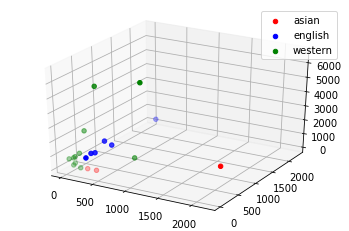

There are 169 unique items
Intersection between unique items and ingredients: 13
Filtered baskets lenght 3811 


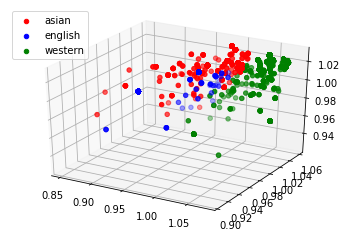

In [14]:
unique_ingredients, vectorizer, centroids = recipes_clusters()
distances, basket_labels = process_baskets(unique_ingredients, vectorizer, centroids)
plot3d(distances, basket_labels)
